# Ödometerversuch Input/Output mit Punkten
## Grundlagen
In diesem Notebook wird der Ödometerversuch <strong>mit</strong> Randbedingungen betrachtet. Die Daten werden mithilfe der vorgegebenen Formeln in PINA berechnet.<br>
Das Problem ist wie folgt definiert:
#### Das Problem ist wie folgt definiert:
$$
\begin{array}{rcl}
    \sigma_{t+1} & = & \sigma_{t}+\Delta\sigma \\ \\
    \Delta\sigma & = & E_s\cdot \Delta\epsilon \\ 
    E_s & = & \frac{1+e_0}{C_c} \cdot \sigma
\end{array}
\hspace{2cm}
\begin{array}{l}
    \textbf{Annahmen:} \\ \\
    \text{Startwert d. Iteration: } \sigma_0 = 1,00 \\ 
    \Delta\epsilon = 0,0005 \\
    e_0 = 1,00 \\ 
    C_c = 0,005
\end{array}
$$

<div = style="text-align: center;">
    <img alt="Problem Oedometer Preview" src="./files/oedometer/problem_preview.png" width="50%" height=auto>
</div>

<br> 

Um das PINA-Model zu testen werden wir folgende vorberechnete Werte verwenden: `Input` {$\sigma_t$; $\Delta\epsilon$; $E_s$; $e_0$; $C_c$}, `Output` {$\sigma_{t+1}$}.

## Einstellungen

In [7]:
import ipywidgets as widgets
from IPython.display import display

# Checkbox erstellen
debug_mode = widgets.Checkbox(
    value=True,  # Standard: Ausgeschaltet
    description="Debug Mode aktivieren",
    disabled=False
)

normalize_data = widgets.Checkbox(
    value=False,  # Standard: Ausgeschaltet
    description="Daten normalisieren",
    disabled=False
)

# Checkbox anzeigen
display(debug_mode)
display(normalize_data)


Checkbox(value=True, description='Debug Mode aktivieren')

Checkbox(value=False, description='Daten normalisieren')

## Problemdefinition

### Hinweise
- Input und Output Werte müssen aus der Excel als Condition übergeben werden.
- Auch wenn die `domain` nicht verwendet wird, muss diese definiert sein und darf nicht leer sein! Generell ist dieses Attribut notwendig um den Wertebereich für die Datengenerierung zu bestimmen.
  - Siehe Kommentar `problem.discretise_domain`. 

In [17]:
from pina.problem import AbstractProblem
from pina.geometry import CartesianDomain
from pina.equation import Equation, FixedValue
from pina import Condition
class SimpleODE(AbstractProblem):

    # Definition der Eingabe- und Ausgabevariablen basierend auf LabelTensor
    input_variables = ['sigma_t', 'C_c', 'delta_epsilon', 'e_0']
    output_variables = ['sigma_t_p1']

    # Wertebereich
    # Fix values [delta_epsilon, e_0, C_c]
    domain = CartesianDomain({'e_0': [0, 1], 'C_c' : [0, 1], 'sigma_t': [1, 1], 'delta_epsilon' : [0, 1]})  # Wertebereich immer definieren!

    def calc_sigma_t_p1(input_, output_):      
        
        def elastity():
            e_0 = input_.extract(['e_0'])
            C_c = input_.extract(['C_c'])
            sigma_t = input_extract(['sigma_t'])
            return (1 + e_0) / C_c * sigma_t
    
        def additional_stress():
            return elastity() * input_.extract(['delta_epsilon'])      

        return input_extract(['sigma_t']) + additional_stress()

        
    
    # Definition der Randbedingungen und vorberechnetet Punkte
    conditions = {
        # We fix initial condition to value 1
        'fix_e_0': Condition(location=CartesianDomain({'e_0': 0.}), equation=FixedValue(1.)),
        'fix_C_c': Condition(location=CartesianDomain({'C_c': 0.}), equation=FixedValue(0.005)),
        'fix_delta_epsilon': Condition(location=CartesianDomain({'delta_epsilon': 0.}), equation=FixedValue(0.0005)),
        'fix_start_sigma': Condition(location=CartesianDomain({'sigma_t': 0.}), equation=FixedValue(1.)),
        # We wrap the python equation using Equation
        'data_sigma_t_p1': Condition(location=CartesianDomain({'e_0': [0,1], 'C_c': [0,1], 'sigma_t': [0,1], 'delta_epsilon': [0, 1]}), equation=Equation(calc_sigma_t_p1)), 
    }

    # Methode zur Definition der "wahren Lösung" des Problems
    def truth_solution(self, pts):
        return torch.exp(pts.extract(['sigma_0']))

# Problem-Instanz erzeugen
problem = SimpleODE()

# Datengenerierung, falls Randbedingungen definiert
problem.discretise_domain(1, 'random', locations=['fix_e_0'])
problem.discretise_domain(1, 'random', locations=['fix_C_c'])
problem.discretise_domain(1, 'random', locations=['fix_delta_epsilon'])
problem.discretise_domain(n=50, mode='random', variables=['sigma_t'], locations=['data_sigma_t_p1'])

if debug_mode.value:
    # Debugging-Ausgaben
    print("Geladene Input Variablen: ", problem.input_variables)
    print("Geladene Output Variablen: ", problem.output_variables)
    print('Input points:', problem.input_pts)

Geladene Input Variablen:  ['sigma_t', 'C_c', 'delta_epsilon', 'e_0']
Geladene Output Variablen:  ['sigma_t_p1']
Input points: {'fix_e_0': LabelTensor([[[0.]]]), 'fix_C_c': LabelTensor([[[0.]]]), 'fix_delta_epsilon': LabelTensor([[[0.]]]), 'data_sigma_t_p1': LabelTensor([[[0.0301]],
             [[0.2496]],
             [[0.8264]],
             [[0.4011]],
             [[0.3892]],
             [[0.7895]],
             [[0.3216]],
             [[0.7588]],
             [[0.7048]],
             [[0.0802]],
             [[0.1189]],
             [[0.7084]],
             [[0.2564]],
             [[0.1389]],
             [[0.5334]],
             [[0.1421]],
             [[0.1614]],
             [[0.3667]],
             [[0.6571]],
             [[0.1773]],
             [[0.6628]],
             [[0.0531]],
             [[0.6288]],
             [[0.5903]],
             [[0.8231]],
             [[0.6918]],
             [[0.8396]],
             [[0.7127]],
             [[0.3954]],
             [[0

## Visualisierung Sampling
Darstellung Input: `sigma_0` und `delta_epsilon`

ValueError: `delta_epsilon` not in the labels list

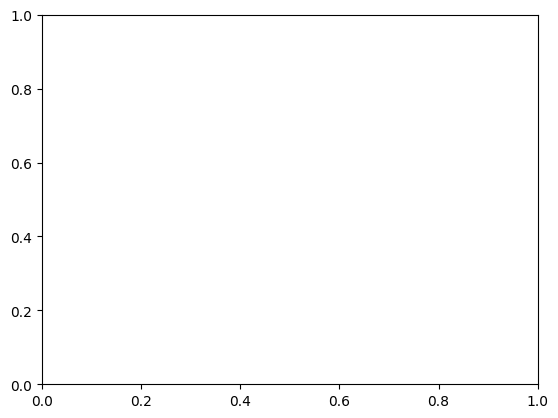

In [16]:
from pina import Plotter

pl = Plotter()
pl.plot_samples(problem=problem, variables=['delta_epsilon','sigma_0'])

In [ ]:
from pina import Trainer
from pina.solvers import PINN
from pina.model import FeedForward
from pina.callbacks import MetricTracker
import torch
from pytorch_lightning.loggers import TensorBoardLogger  # Import TensorBoard Logger

# Überprüfen der Größe der Eingabepunkte und Ausgabepunkte
print("Länge der Eingabepunkte (input_pts):", len(problem.input_pts['data']))
print("Länge der Ausgabepunkte (output_pts):", len(problem.output_pts))

# Model erstellen
model = FeedForward(
    layers=[50, 50, 50],
    func=torch.nn.ReLU,
    output_dimensions=len(problem.output_variables),
    input_dimensions=len(problem.input_variables)
)

# PINN-Objekt erstellen
pinn = PINN(problem, model)

# TensorBoard-Logger einrichten
logger = TensorBoardLogger("tensorboard_logs", name="pina_experiment")

# Trainer erstellen mit TensorBoard-Logger
trainer = Trainer(
    solver=pinn,
    max_epochs=200,
    callbacks=[MetricTracker()],
    batch_size=1,
    accelerator='cpu',
    logger=logger,
    enable_model_summary=False,
)


# Training starten
trainer.train()

# Inspect final loss
trainer.logged_metrics


In [ ]:
import matplotlib.pyplot as plt
import torch

# Erstelle die Eingabedaten als LabelTensor für das trainierte Modell
input_data = LabelTensor(torch.tensor(
    np.column_stack((data_dict['sigma_0'], data_dict['delta_epsilon'])), dtype=torch.float
), ['sigma_0', 'delta_epsilon'])

# Model-Vorhersage für sigma_1 berechnen
sigma_1_pred = pinn(input_data).detach().numpy()

# Plot der wahren vs. vorhergesagten Werte
plt.figure(figsize=(8, 5))

plt.plot(data_dict['sigma_0'], data_dict['sigma_1'], label="True Solution (sigma_1)", linestyle='dashed', color='blue')
plt.plot(data_dict['sigma_0'], sigma_1_pred, label="NN Prediction (sigma_1)", linestyle='solid', color='red')

plt.xlabel("sigma_0")
plt.ylabel("sigma_1")
plt.title("Prediction vs. True Solution (delta_epsilon=0.0005)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
pl.plot(solver=pinn)

## Visualisierung Loss-Kurve


In [ ]:
# plotting the solution
pl.plot_loss(trainer, label='mean_loss', logy=True)